# Land Use Land Cover Classification from SAR imagery using Automated Deep Learning
* 🔬 Data Science
* 🥠 Deep Learning and Object Detection

## Table of Contents
* [Introduction and objective](#Introduction-and-objective)
* [Part 1 - Export training data](#Part-1---Export-training-data)
* [Part 2 - model training](#Part-2---model-training)
    * [Necessary imports](#Necessary-imports)
    * [Prepare data that will be used for training](#Prepare-data-that-will-be-used-for-training)
    * [Visualize training data](#Visualize-training-data)
    * [Load model architecture](#Load-model-architecture)
    * [Train the model](#Train-the-model)
    * [Classify and visualize land use land cover in validation set](#Detect-and-visualize-land-use-land-cover-in-validation-set)
    * [Save the model](#Save-the-model) 
* [Part 3 - Model inference](#Part-3---Model-inference)
    * [Visualize results on map](#Visualize-results-on-map)
* [Conclusion](#Conclusion)

## Introduction and objective

Remotely sensed imagery enables consistent and large-scale monitoring of land cover, helping to detect spatial changes over time. Among these, Synthetic Aperture Radar (SAR) data is particularly valuable due to its ability to capture cloud-free imagery under all weather and lighting conditions, making it ideal for continuous Land Use/Land Cover (LULC) analysis. This notebook presents an end-to-end deep learning workflow using the `ArcGIS API for Python`, enhanced by `AutoDL` (Automated Deep Learning)—a tool that automates model selection, architecture optimization, and hyperparameter tuning based on the input training data. By integrating AutoDL, the workflow becomes more efficient and accessible, reducing the need for extensive manual experimentation while maintaining high model performance. The process includes extracting training samples, training a pixel-based classification model using SAR data, and deploying the model for inference to generate accurate, large-area LULC maps.

### Necessary imports

In [1]:
import os
from pathlib import Path
from arcgis.gis import GIS
from arcgis.learn import prepare_data, AutoDL, ImageryModel, MMSegmentation

## Part 1 - Export training data

To export training data, we will use a classified raster that contains the land use and land cover classes of the study area, and a raster layer that contains all the pixels and band information. In this notebook, we have created the corresponding classified raster using the [Land Cover Classification (Sentinel-2)](https://www.arcgis.com/home/item.html?id=afd124844ba84da69c2c533d4af10a58) from the [ArcGIS Living Atlas of the World](https://livingatlas.arcgis.com/en/browse/?q=deep%20learning#d=2&q=deep%20learning) and Sentinel-2 imagery.

In [2]:
from arcgis.gis import GIS
gis = GIS('home')

<Item title:"sar_imagery_for_training" type:Tiled Imagery Layer owner:api_data_owner>
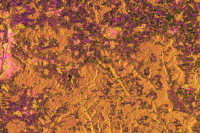

In [3]:
sar_raster = gis.content.get('c3fa31a5683149b29914796114d385ba')
sar_raster

<Item title:"lulc_imagery_for_training" type:Tiled Imagery Layer owner:api_data_owner>
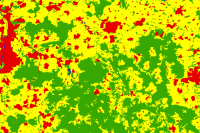

In [4]:
lulc_raster = gis.content.get('a9ab3e2acb354cd99db58a4447c655b9')
lulc_raster

With the classified raster and Sentinel-1 imagery, we are now ready to export training data using the 'Export Training Data For Deep Learning' tool in arcgis Pro. In addtion to classified raster, raster layer, and output folder, we also need to speficy a few other parameters such as tile size (size of the image chips), stride size (distance to move in the X when creating the next image chip), chip format (TIFF, PNG, or JPEG), metadata format (how we are going to store those bounding boxes). 

Depending on the size of your data, tile and stride size, and computing resources, this opertation can take 15mins~2hrs in our experiment. Also, do not re-run it if you already run it once unless you would like to update the setting.

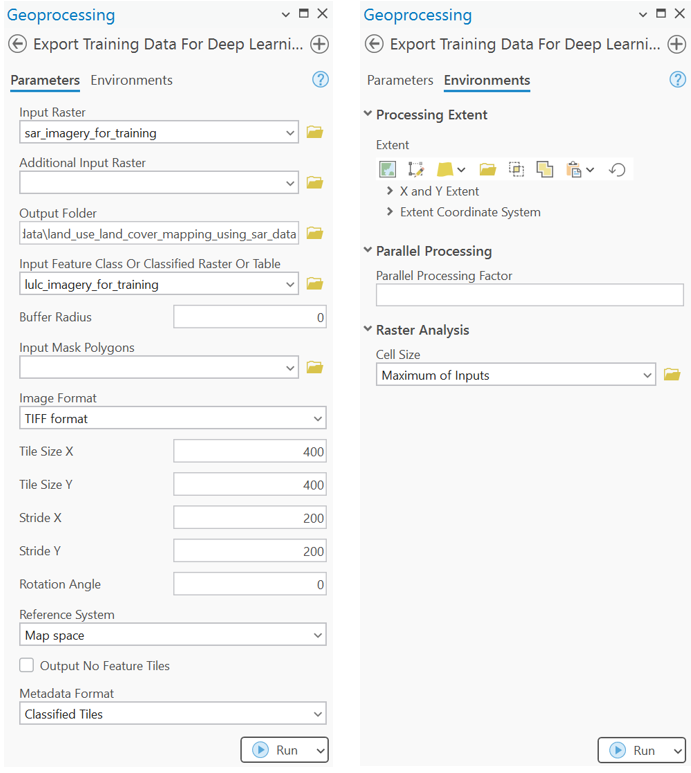

## Part 2 - model training

We have already exported the data, and it can be directly downloaded using the following steps:

<Item title:"land_use_land_cover_mapping_using_sar_data" type:Image Collection owner:api_data_owner>
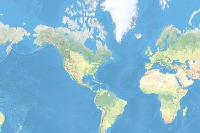

In [6]:
training_data = gis.content.get('3b5c8883d5994d53b74919d3888bfefe')
training_data

In [6]:
filepath = training_data.download(file_name=training_data.name)

In [7]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [8]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [9]:
data_path

WindowsPath('C:/Users/shi10484/AppData/Local/Temp/land_use_land_cover_mapping_using_sar_data')

### Prepare data that will be used for training

In [2]:
data = prepare_data(r'E:\sar_lulc\land_use_land_cover_mapping_using_sar_data', 
                    batch_size=2, 
                    chip_size=400)

In [3]:
data

ImageDataBunch;

Train: LabelList (340 items)
x: ArcGISSegmentationItemList
ArcGISMSImage (3, 400, 400),ArcGISMSImage (3, 400, 400),ArcGISMSImage (3, 400, 400),ArcGISMSImage (3, 400, 400),ArcGISMSImage (3, 400, 400)
y: ArcGISSegmentationLabelList
ArcGISImageSegment (1, 400, 400),ArcGISImageSegment (1, 400, 400),ArcGISImageSegment (1, 400, 400),ArcGISImageSegment (1, 400, 400),ArcGISImageSegment (1, 400, 400)
Path: E:\sar_lulc\land_use_land_cover_mapping_using_sar_data\images;

Valid: LabelList (37 items)
x: ArcGISSegmentationItemList
ArcGISMSImage (3, 400, 400),ArcGISMSImage (3, 400, 400),ArcGISMSImage (3, 400, 400),ArcGISMSImage (3, 400, 400),ArcGISMSImage (3, 400, 400)
y: ArcGISSegmentationLabelList
ArcGISImageSegment (1, 400, 400),ArcGISImageSegment (1, 400, 400),ArcGISImageSegment (1, 400, 400),ArcGISImageSegment (1, 400, 400),ArcGISImageSegment (1, 400, 400)
Path: E:\sar_lulc\land_use_land_cover_mapping_using_sar_data\images;

Test: None

### Visualize training data
To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualize them.

CPU times: total: 17.9 s
Wall time: 1.01 s


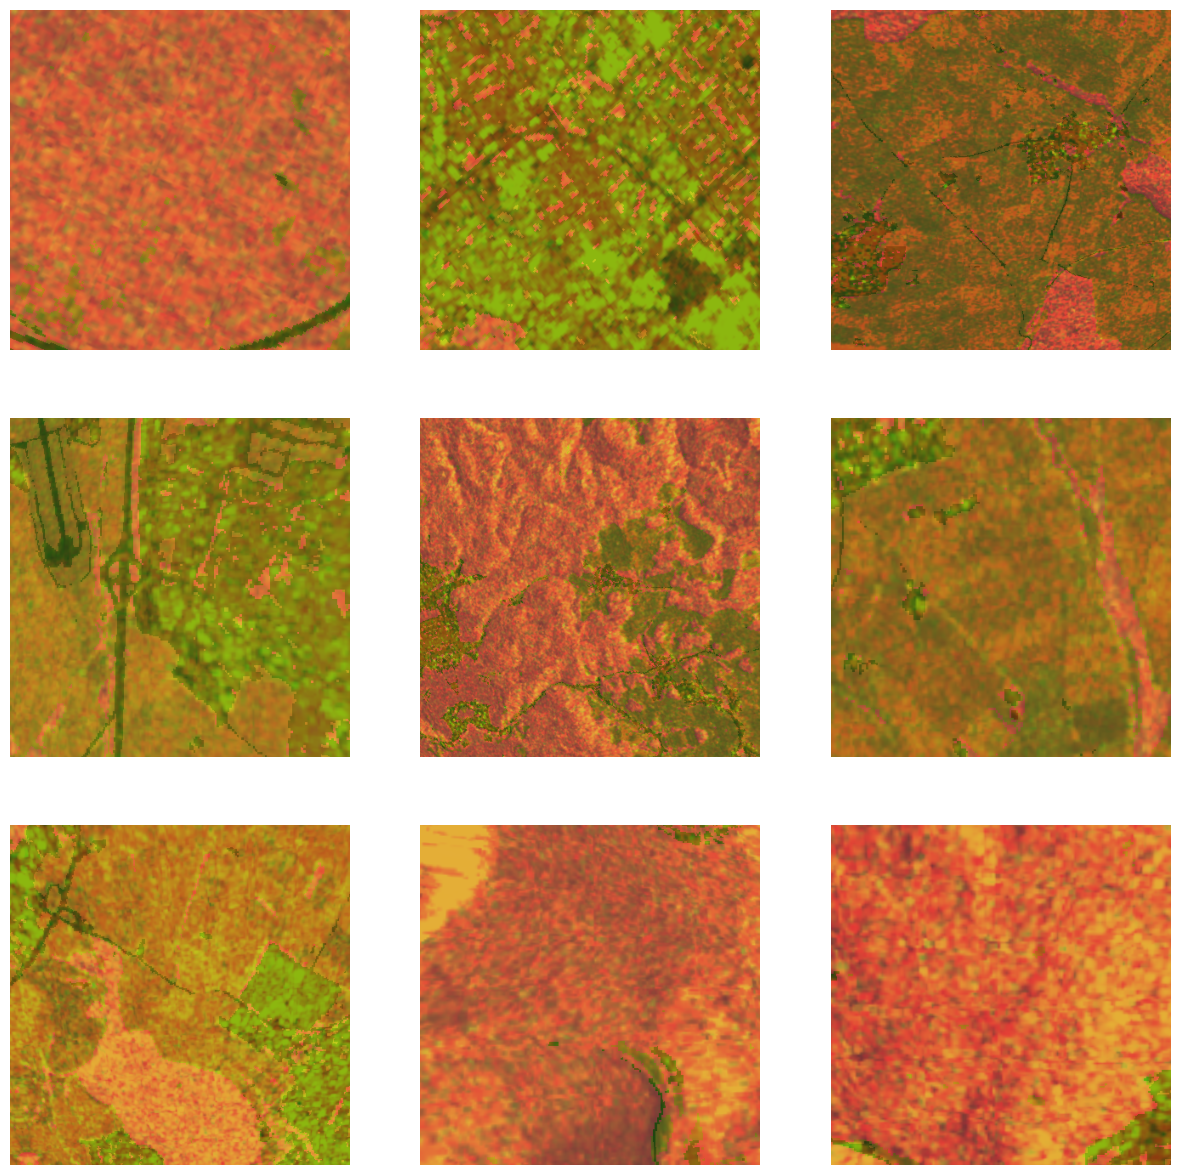

In [4]:
%%time
data.show_batch(alpha=0.7)

### Load model architecture


In [5]:
model = AutoDL(data, total_time_limit=2)

Given time to process the dataset is: 2.0 hours
Number of images that can be processed in the given time: 49
Time required to process the entire dataset of 377 images is 15.2 hours


In [6]:
%%time
model.fit()

14-04-2025 11:24:36: Selected networks: DeepLab UnetClassifier PSPNetClassifier SamLoRA ANN APCNet CCNet CGNet HRNet Mask2Former DeepLabV3Plus DMNet DNLNet EMANet FastSCNN FCN GCNet MobileNetV2 NonLocalNet PSANet SemFPN UperNet
14-04-2025 11:24:36: Current network - DeepLab. 
14-04-2025 11:24:36: Total time alloted to train the DeepLab model is 0:02:36
14-04-2025 11:24:36: Maximum number of epochs will be 20 to train DeepLab
14-04-2025 11:24:36: Initializing the DeepLab network.
14-04-2025 11:26:23: DeepLab initialized with resnet101 backbone
14-04-2025 11:26:23: finding desired batch size for the data object.
14-04-2025 11:26:23: Optimized batch size for DeepLab with the selected backbone is 32
14-04-2025 11:30:42: Best learning rate for DeepLab with the selected data is 0.0008317637711026709
14-04-2025 11:30:42: Fitting DeepLab
14-04-2025 11:33:47: Training completed
14-04-2025 11:33:47: Computing the network metrices
14-04-2025 11:33:49: Finished training DeepLab.
14-04-2025 11:33:4

14-04-2025 13:37:14: Finished training Mask2Former.
14-04-2025 13:37:14: Exiting.
14-04-2025 13:37:14: Saving the model
Computing model metrics...
14-04-2025 13:38:22: model saved at E:\sar_lulc\land_use_land_cover_mapping_using_sar_data\models\AutoDL_Mask2Former_resnet34_2025-04-14_13-37-09
14-04-2025 13:38:22: deleting Mask2Former with resnet34
14-04-2025 13:38:23: Current network - DeepLabV3Plus. 
14-04-2025 13:38:23: Total time alloted to train the DeepLabV3Plus model is 0:06:51
14-04-2025 13:38:23: Insufficient time to train the DeepLabV3Plus for 20 epochs. 0 epochs can only be trained in the remaining time.
14-04-2025 13:38:23: The time left to train the DeepLabV3Plus is not sufficent.
14-04-2025 13:38:23: Remaining networks will be skipped due to limited time, Stopping the training process.
14-04-2025 13:38:23: Collating and evaluating model performances.
14-04-2025 13:38:23: Exiting.
CPU times: total: 11h 4min 40s
Wall time: 2h 13min 47s


In [7]:
model.score()

Model  train_loss  valid_loss  accuracy      dice        lr  \
0             HRNet    0.666629    0.561574  0.808551  0.808551  0.000479   
1               ANN    1.520766    1.087497  0.777355  0.777355  0.000479   
2             CCNet    1.632814    1.195607  0.766691  0.766691  0.000331   
3            APCNet    1.419793    0.963423  0.753994  0.753994  0.001000   
4           DeepLab    1.321346    1.090469  0.717988  0.719207  0.000832   
5  PSPNetClassifier    1.419132    2.025330  0.566628  0.594162  0.001738   
6       Mask2Former   80.755592   75.659645  0.485950  0.485950  0.000076   
7    UnetClassifier    1.520223    1.192252  0.409058  0.409058  0.000063   
8             CGNet    1.515340    1.440403  0.397604  0.415047  0.000398   
9           SamLoRA    1.099040    0.943550  0.191824  0.192380  0.000036   

  training time   backbone  
0       0:23:40   resnet34  
1       0:14:40   resnet34  
2       0:11:00   resnet34  
3       0:12:02   resnet34  
4       0:09:11  resnet101  
5       0:10:20   resnet50  
6       0:20:52   resnet34  
7       0:16:27   resnet34  
8       0:04:12   resnet34  
9       0:06:15      vit_b

show_results will only show the output from the best performing model: HRNet


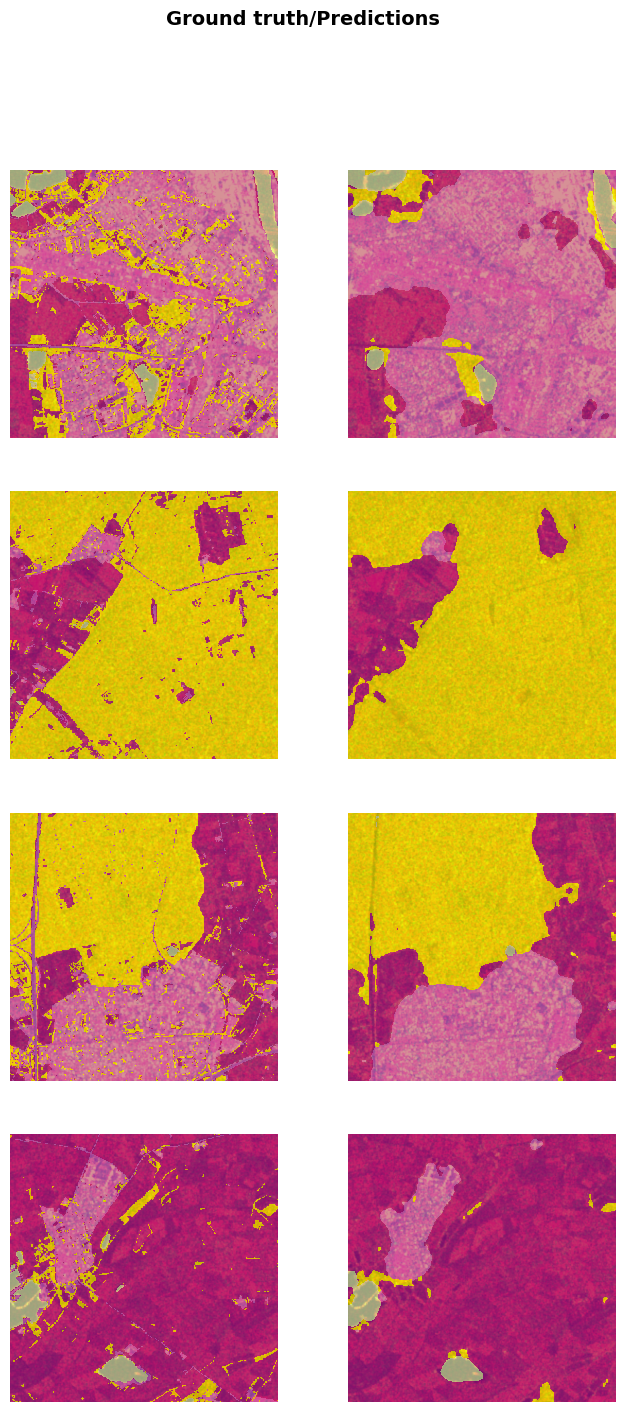

In [10]:
model.show_results(alpha=0.8)

In [21]:
model.mIOU()

Model    0  Artificial surfaces  Forest and natural areas  \
0           DeepLab  0.0             0.529560                  0.566094   
0    UnetClassifier  0.0             0.048229                  0.277975   
0  PSPNetClassifier  0.0             0.399795                  0.502778   
0           SamLoRA  0.0             0.034245                  0.216421   
0               ANN  0.0             0.551148                  0.653254   
0            APCNet  0.0             0.536048                  0.658247   
0             CCNet  0.0             0.523363                  0.636660   
0             CGNet  0.0             0.129727                  0.195238   
0             HRNet  0.0             0.589420                  0.689896   
0       Mask2Former  0.0             0.042162                  0.387044   

   Agricultural areas  Water bodies  
0            0.654293      0.138373  
0            0.310274      0.002862  
0            0.449455      0.071270  
0            0.098781      0.029934  
0            0.663272      0.482308  
0            0.649858      0.334599  
0            0.679304      0.369035  
0            0.394160      0.010579  
0            0.718942      0.612020  
0            0.339223      0.000000

In [15]:
finetune_model = ImageryModel()

In [26]:
path = r"<path_to_best_performing_model>"
finetune_model.load(path, data)

### Train the model

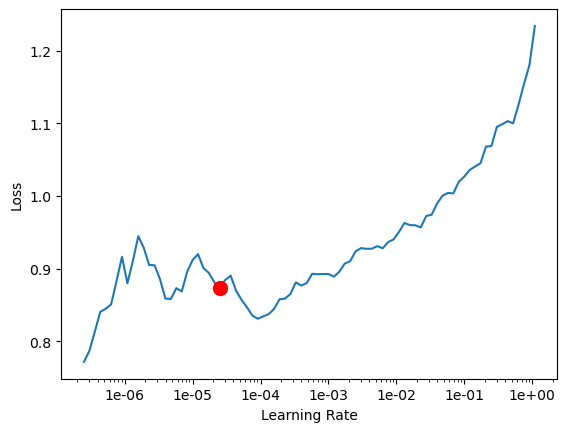

In [28]:
lr = finetune_model.lr_find()

In [29]:
finetune_model.fit(epochs=80, lr=lr)

In [30]:
finetune_model.mIOU()

{'0': 0.0,
 'Artificial surfaces': 0.6378879394287942,
 'Forest and natural areas': 0.7380598395930081,
 'Agricultural areas': 0.7591309650169241,
 'Water bodies': 0.7575791601161209}

In [31]:
finetune_model.save('lulc_80e')

Computing model metrics...


WindowsPath('E:/sar_lulc/land_use_land_cover_mapping_using_sar_data/models/lulc_80e')

### Extract and visualize LULC in validation set
It's a good practice to see results of the model vis-a-vis ground truth. The code below picks random samples and shows us ground truths and model predictions, side by side. This enables us to preview the results of the model within the notebook.

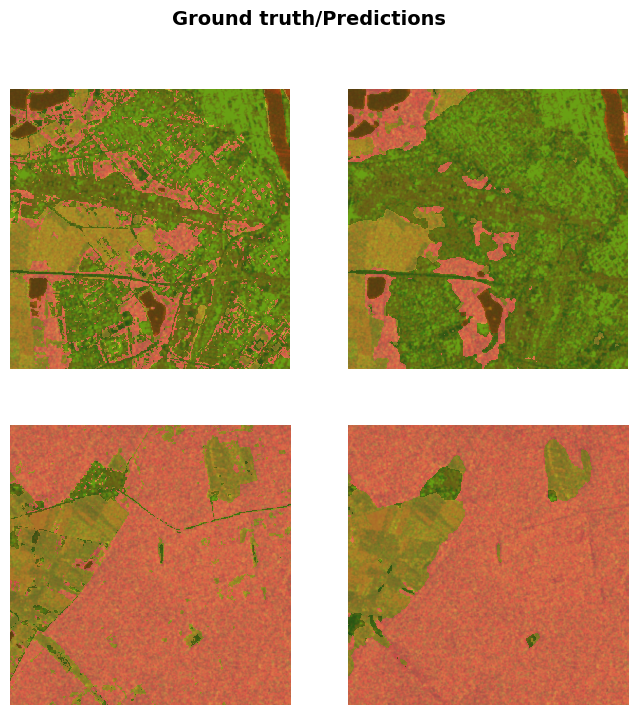

In [34]:
finetune_model.show_results(alpha=0.8)

As we can see, with only 20 epochs, we are already seeing reasonable results. Further improvment can be acheived through more sophisticated hyperparameter tuning. Let's save the model for further training or inference later. The model should be saved into a models folder in your folder. By default, it will be saved into your `data_path` that you specified in the very beginning of this notebook.

In [38]:
finetune_model.save('sar_lulc', publish=True, overwrite=True)

Published DLPK Item Id: 11cde952831c467b91be4a342cc803aa


WindowsPath('E:/sar_lulc/land_use_land_cover_mapping_using_sar_data/models/sar_lulc')

## Part 3 -  Model inference

Using ArcGIS Pro, we can use the trained model on a test image/area to classify LULC in the SAR satellite image.

After training the `HRNet` model and saving the weights for classifying images, we can use the Classify Pixels Using Deep Learning tool tool available in ArcGIS pro and ArcGIS Enterprise for inferencing.

<Item title:"sar_lulc" type:Deep Learning Package owner:api_data_owner>
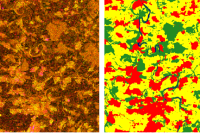

In [29]:
sar_lulc_model = gis.content.get('11cde952831c467b91be4a342cc803aa')
sar_lulc_model

<Item title:"SARImagery2024" type:Tiled Imagery Layer owner:api_data_owner>
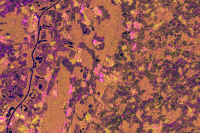

In [28]:
raster_for_inferencing = gis.content.get('ba9e5ed7c74548e0be4bafbccd2d2ae3')
raster_for_inferencing

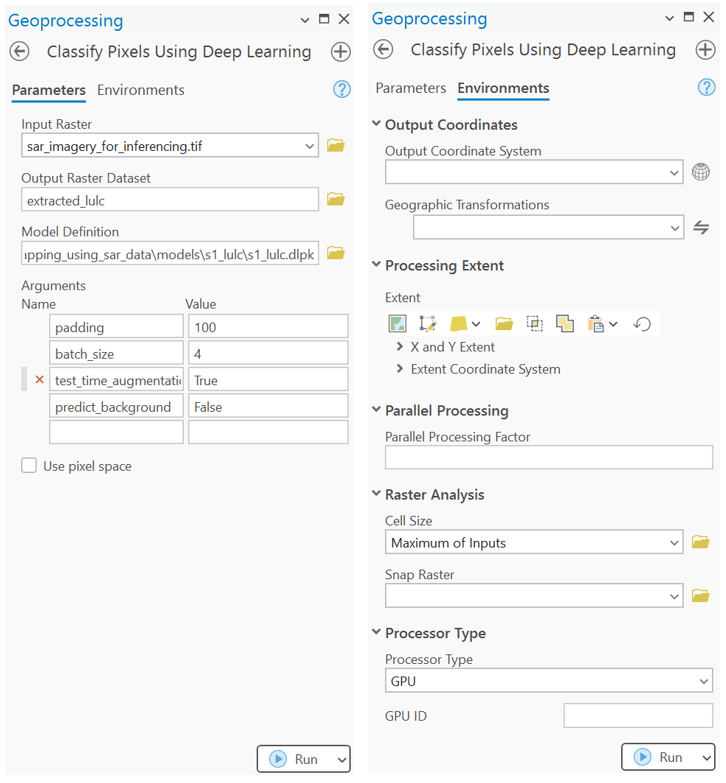

## Visualize results on map

In [30]:
s1_ras = gis.content.get('ba9e5ed7c74548e0be4bafbccd2d2ae3')
s1_inf_ras = gis.content.get('6a2ec2215208436993f67b6a330d3477')

In [31]:
from arcgis.raster import colormap
s1_inf_cmap = colormap(s1_inf_ras.layers[0], colormap=[[1, 255, 0, 0],[2, 34, 139, 34],[3, 255, 255, 0],[4, 0, 0, 128]])

In [32]:
m1 = gis.map('Atlanta, USA')
m1.basemap.basemap = 'arcgis-imagery'
m1.zoom = 11
m2 = gis.map('Atlanta, USA')
m2.content.add(s1_ras.layers[0])
m2.zoom_to_layer(s1_ras.layers[0])
m2.zoom = 11
m3 = gis.map('Atlanta, USA')
m3.content.add(s1_inf_cmap)
m3.zoom = 11

In [33]:
from ipywidgets import HBox, VBox, Label, Layout

In [34]:
m2.sync_navigation(m1)
m2.sync_navigation(m3)

In [35]:
from ipywidgets import *

m1.layout = Layout(flex = '1 1', padding = '10px')
m2.layout = Layout(flex = '1 1', padding = '10px')
m3.layout = Layout(flex = '1 1', padding = '10px')

# Create VBoxes for each map and label
box1 = VBox([Label("True Colour Imagery"), m1], layout=Layout(width='33%'))
box2 = VBox([Label("Sentinel-1 Imagery"), m2], layout=Layout(width='33%'))
box3 = VBox([Label("LULC Classification Predictions"), m3], layout=Layout(width='33%'))

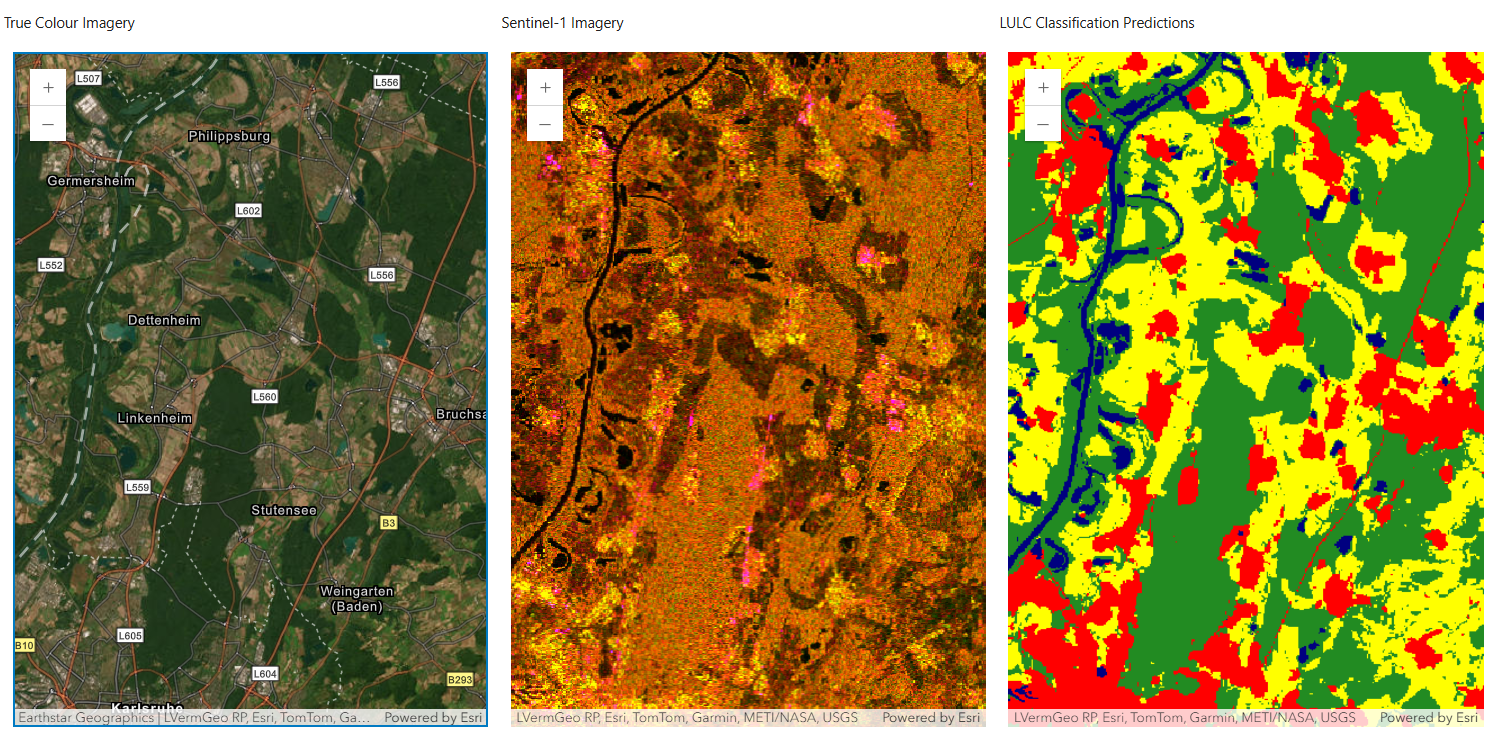

In [37]:
# Place the VBoxes side by side using an HBox
hbox = HBox([box1, box2, box3])

# Display the HBox
hbox

## Conclusion
In this notebook, we have demonstrated how to use AutoDL, an automated deep learning framework, to perform Land Use/Land Cover (LULC) classification using Sentinel-1 SAR data. In Part 1, we explored how AutoDL can automatically select the most suitable model architecture and training configuration based on the input data, significantly reducing manual effort and improving model performance. This process involved preparing and preprocessing Sentinel-1 SAR imagery, training a pixel-based classification model, visualizing the LULC results, and generating accuracy metrics for evaluation. Finally, in Part 2, we applied the trained model to a test area to produce the classified LULC map and assess the distribution of different land cover types. The use of SAR data proved especially valuable due to its ability to capture surface information under all weather and lighting conditions, making it a reliable source for year-round land cover mapping.